<a href="https://colab.research.google.com/github/vishal-burman/PyTorch-Architectures/blob/master/modeling_SSE/test_sample_SSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! rm -rf PyTorch-Architectures/
! git clone https://github.com/vishal-burman/PyTorch-Architectures.git

Cloning into 'PyTorch-Architectures'...
remote: Enumerating objects: 136, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 1074 (delta 63), reused 91 (delta 33), pack-reused 938
Receiving objects: 100% (1074/1074), 8.48 MiB | 24.60 MiB/s, done.
Resolving deltas: 100% (634/634), done.


In [2]:
%cd PyTorch-Architectures/modeling_SSE/

/content/PyTorch-Architectures/modeling_SSE


In [3]:
import time
import pdb
from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors, GloVe
import torch
import torch.nn as nn
import torch.nn.functional as F
from model import BiLSTMSE

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
tokenize = lambda x: x.split()
TEXT = data.Field(sequential=True, tokenize=tokenize, lower=True, include_lengths=True, batch_first=True, fix_length=200)
LABEL = data.LabelField()
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
TEXT.build_vocab(train_data, vectors=GloVe(name='6B', dim=300))
LABEL.build_vocab(train_data)
word_embeddings = TEXT.vocab.vectors
train_data, valid_data = train_data.split()
train_iter, valid_iter, test_iter = data.BucketIterator.splits((train_data, valid_data, test_data), batch_size=32, sort_key=lambda x: len(x.text), repeat=False, shuffle=True)

aclImdb_v1.tar.gz:   0%|          | 0.00/84.1M [00:00<?, ?B/s]

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:03<00:00, 22.7MB/s]
.vector_cache/glove.6B.zip: 862MB [06:28, 2.22MB/s]                           
100%|█████████▉| 399427/400000 [00:36<00:00, 10696.95it/s]

In [5]:
print('Length of Training Iterator: ', len(train_iter))
print('Length of Valid Iterator: ', len(valid_iter))

Length of Training Iterator:  547
Length of Valid Iterator:  235


In [6]:
# Parameters
vocab_size = len(TEXT.vocab)
emb_dim = 300
hidden_dim = 300
n_layers = 2
natt_unit = 300
natt_hops = 1
nfc = 512
n_class = 2
drop_prob = 0.5
penal_coeff = 0.1
learning_rate = 0.001

In [7]:
model = BiLSTMSE(
    vocab_size=vocab_size,
    emb_dim=emb_dim,
    hidden_dim=hidden_dim,
    n_layers=n_layers,
    natt_unit=natt_unit,
    natt_hops=natt_hops,
    nfc=nfc,
    n_class=n_class,
    drop_prob=drop_prob,
    weights=word_embeddings,
)
model = model.to(device)

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
def loss_fn(x, y, model, penal_coeff, device):
  pred, att = model(x)
  loss = F.cross_entropy(pred, y)

  # Penalty
  div_penalty = (att @ att.transpose(1, 2)) - torch.eye(att.size(1)).to(device)
  loss = loss + penal_coeff * torch.linalg.norm(div_penalty, dim=(1, 2))
  loss = torch.mean(loss)
  return pred, loss

def compute_accuracy(model, data_loader, device):
  correct_examples = 0
  num_examples = 0
  model.eval()
  with torch.set_grad_enabled(False):
    for idx, batch in enumerate(data_loader):
      text = batch.text[0].to(device)
      if text.size(0) is not 32:
        continue
      target = batch.label.to(device)
      logits, _ = model(text)
      logits = F.softmax(logits, dim=-1)
      _, preds = torch.max(logits, 1)
      correct_examples += (preds == target).sum()
      num_examples += target.size(0)
  return correct_examples.float() / num_examples * 100

EPOCHS = 4
start_time = time.time()
for epoch in range(EPOCHS):
  model.train()
  for idx, batch in enumerate(train_iter):
    text = batch.text[0].to(device)
    label = batch.label.to(device)

    if text.size(0) is not 32: # irregular behaviour in one batch
      continue
    
    optimizer.zero_grad()
    pred, loss = loss_fn(text, label, model, penal_coeff, device)
    # LOGGING
    if idx % 100 == 0:
      # print('Loss: ', loss)
      print('Batch: %04d/%04d || Epoch: %04d/%04d || Loss: %.2f' % (idx, len(train_iter), epoch+1, EPOCHS, loss))
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
    optimizer.step()
  with torch.set_grad_enabled(False):
    train_acc = compute_accuracy(model, train_iter, device)
    valid_acc = compute_accuracy(model, valid_iter, device)
    print('Training Accuracy: ', train_acc)
    print('Valid Accuracy: ', valid_acc)
  epoch_elapsed_time = (time.time() - start_time) / 60
  print('Epoch Elapsed Time: ', epoch_elapsed_time)
total_training_time = (time.time() - start_time) / 60
print('Total Training Time: ', total_training_time)

Batch: 0000/0547 || Epoch: 0001/0004 || Loss: 0.80
Batch: 0100/0547 || Epoch: 0001/0004 || Loss: 0.76
Batch: 0200/0547 || Epoch: 0001/0004 || Loss: 0.60
Batch: 0300/0547 || Epoch: 0001/0004 || Loss: 0.60
Batch: 0400/0547 || Epoch: 0001/0004 || Loss: 0.70
Batch: 0500/0547 || Epoch: 0001/0004 || Loss: 0.45
Training Accuracy:  tensor(91.3290, device='cuda:0')
Valid Accuracy:  tensor(83.3467, device='cuda:0')
Epoch Elapsed Time:  1.2740498622258505
Batch: 0000/0547 || Epoch: 0002/0004 || Loss: 0.34
Batch: 0100/0547 || Epoch: 0002/0004 || Loss: 0.35
Batch: 0200/0547 || Epoch: 0002/0004 || Loss: 0.38
Batch: 0300/0547 || Epoch: 0002/0004 || Loss: 0.31
Batch: 0400/0547 || Epoch: 0002/0004 || Loss: 0.30
Batch: 0500/0547 || Epoch: 0002/0004 || Loss: 0.34
Training Accuracy:  tensor(97.6648, device='cuda:0')
Valid Accuracy:  tensor(84.0678, device='cuda:0')
Epoch Elapsed Time:  2.5784456213315328
Batch: 0000/0547 || Epoch: 0003/0004 || Loss: 0.20
Batch: 0100/0547 || Epoch: 0003/0004 || Loss: 0.21


In [25]:
# Testing some sentences
sentence_1 = "This actor is boring and stupid"
sentence_1 = TEXT.preprocess(sentence_1)
sentence_1 = [[TEXT.vocab.stoi[x] for x in sentence_1]]

model.eval()
with torch.set_grad_enabled(False):
  sentence_1 = torch.tensor(sentence_1).to(device)
  logits, att = model(sentence_1)
  logits = F.softmax(logits, dim=-1)
  _, preds = torch.max(logits, 1)
  if preds.item() is 1:
    print("Positive Sentiment")
  else:
    print("Negative Sentiment")

Negative Sentiment


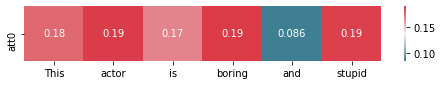

In [26]:
# Visualizing the attention layer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

np.squeeze(att.cpu().numpy(), 0).shape
plt.figure(figsize=(8,1))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(np.squeeze(att.cpu().numpy(), 0), cmap=cmap, annot=True,
            xticklabels=['This', 'actor', 'is', 'boring', 'and', 'stupid'], yticklabels=['att0'])
plt.show()